Adjustments to original code:

- split test train split before --> makes it so there is a seperate testing set --> check of overfitting

- increase batch size 

In [ ]:
#import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from google.colab import drive
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

In [ ]:
#linking to datasets and unzipping files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_metadata_gc.zip'

Archive:  /content/drive/MyDrive/HAM10000_metadata_gc.zip
  inflating: HAM10000_metadata       


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_1_gc'

Streaming output truncated to the last 5000 lines.
  inflating: HAM10000_images_part_1/ISIC_0024306.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024307.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024308.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024309.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024310.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024311.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024312.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024313.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024314.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024315.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024316.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024317.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024318.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024319.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024320.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024321.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024322.jpg  
  inflating: H

In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_2_gc'

Streaming output truncated to the last 5000 lines.
  inflating: HAM10000_images_part_2/ISIC_0029321.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029322.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029323.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029324.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029325.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029326.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029327.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029328.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029329.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029330.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029331.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029332.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029333.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029334.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029335.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029336.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029337.jpg  
  inflating: H

In [ ]:
md = pd.read_csv("/content/HAM10000_metadata")
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [ ]:
#resize images - easier to handle 32X32
im_size = 224 #try 224 and turn GPU on

In [ ]:
#set aside a portion of full dataset for 
dxs = md["dx"].unique()

ldxs = {}

for dx, group in md.groupby("dx"):
    ldxs[dx] = []
    images = list(group["image_id"])
    np.random.shuffle(images)
    for i in range(75):
        ldxs[dx].append(images[i])

In [ ]:
ts = pd.DataFrame.from_dict(ldxs, orient='index')
ts = ts.T
ts

,akiec,bcc,bkl,df,mel,nv,vasc
0,ISIC_0031286,ISIC_0027722,ISIC_0033750,ISIC_0030015,ISIC_0027872,ISIC_0032795,ISIC_0028431
1,ISIC_0025130,ISIC_0030010,ISIC_0028826,ISIC_0027727,ISIC_0028565,ISIC_0026718,ISIC_0032270
2,ISIC_0030826,ISIC_0033579,ISIC_0032654,ISIC_0032138,ISIC_0030211,ISIC_0025290,ISIC_0031197
3,ISIC_0027172,ISIC_0026574,ISIC_0026351,ISIC_0025373,ISIC_0030107,ISIC_0027748,ISIC_0027790
4,ISIC_0032422,ISIC_0027525,ISIC_0028043,ISIC_0028346,ISIC_0032079,ISIC_0032252,ISIC_0027159
...,...,...,...,...,...,...,...
70,ISIC_0024463,ISIC_0024572,ISIC_0029232,ISIC_0025223,ISIC_0030223,ISIC_0028468,ISIC_0024402
71,ISIC_0025350,ISIC_0025700,ISIC_0029929,ISIC_0024553,ISIC_0027130,ISIC_0028480,ISIC_0031217
72,ISIC_0030143,ISIC_0031789,ISIC_0026276,ISIC_0033808,ISIC_0030501,ISIC_0026780,ISIC_0027856
73,ISIC_0028076,ISIC_0032857,ISIC_0030683,ISIC_0030011,ISIC_0033611,ISIC_0031594,ISIC_0027888


In [ ]:
t_akiec_imid = ts.akiec.values.tolist()
t_akiec_dx = ['akiec'] * 75
ts_aikec = pd.DataFrame(list(zip(t_akiec_imid, t_akiec_dx)), columns=['image_id', 'dx'])

t_bcc_imid = ts.bcc.values.tolist()
t_bcc_dx = ['bcc'] * 75
ts_bcc = pd.DataFrame(list(zip(t_bcc_imid, t_bcc_dx)), columns=['image_id', 'dx'])

t_bkl_imid = ts.bkl.values.tolist()
t_bkl_dx = ['bkl'] * 75
ts_bkl = pd.DataFrame(list(zip(t_bkl_imid, t_bkl_dx)), columns=['image_id', 'dx'])

t_df_imid = ts.df.values.tolist()
t_df_dx = ['df'] * 75
ts_df = pd.DataFrame(list(zip(t_df_imid, t_df_dx)), columns=['image_id', 'dx'])

t_mel_imid = ts.mel.values.tolist()
t_mel_dx = ['mel'] * 75
ts_mel = pd.DataFrame(list(zip(t_mel_imid, t_mel_dx)), columns=['image_id', 'dx'])

t_nv_imid = ts.nv.values.tolist()
t_nv_dx = ['nv'] * 75
ts_nv = pd.DataFrame(list(zip(t_nv_imid, t_nv_dx)), columns=['image_id', 'dx'])

t_vasc_imid = ts.vasc.values.tolist()
t_vasc_dx = ['vasc'] * 75
ts_vasc = pd.DataFrame(list(zip(t_vasc_imid, t_vasc_dx)), columns=['image_id', 'dx'])

ts_balanced = pd.concat([ts_aikec, ts_bcc, ts_bkl, ts_df, ts_mel, ts_nv, ts_vasc])
ts_balanced

,image_id,dx
0,ISIC_0031286,akiec
1,ISIC_0025130,akiec
2,ISIC_0030826,akiec
3,ISIC_0027172,akiec
4,ISIC_0032422,akiec
...,...,...
70,ISIC_0024402,vasc
71,ISIC_0031217,vasc
72,ISIC_0027856,vasc
73,ISIC_0027888,vasc


In [ ]:
cond = md['image_id'].isin(ts_balanced['image_id'])
trainset = md.drop(md[cond].index)

trainset

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [ ]:
#label encoding: going from text to numerical
lab_enc = LabelEncoder()
lab_enc.fit(trainset['dx'])
LabelEncoder()
print(list(lab_enc.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
lab_enc = LabelEncoder()
lab_enc.fit(ts_balanced['dx'])
LabelEncoder()
print(list(lab_enc.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
#label column in md - diagnosis and numerical label in one dataset
trainset['label'] = lab_enc.transform(trainset["dx"]) 
ts_balanced['label'] = lab_enc.transform(ts_balanced["dx"]) 
trainset

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0


In [ ]:
ts_balanced

,image_id,dx,label
0,ISIC_0031286,akiec,0
1,ISIC_0025130,akiec,0
2,ISIC_0030826,akiec,0
3,ISIC_0027172,akiec,0
4,ISIC_0032422,akiec,0
...,...,...,...
70,ISIC_0024402,vasc,6
71,ISIC_0031217,vasc,6
72,ISIC_0027856,vasc,6
73,ISIC_0027888,vasc,6


In [ ]:
#get all file paths and make a new column
fldr1 = '/content/HAM10000_images_part_1'
fldr2 = '/content/HAM10000_images_part_2'

im_paths = []

for i in trainset['image_id']:
  fid = i

  fn = '/' + fid + '.jpg'

  if os.path.isfile(fldr1 + fn) == True:
    im_paths.append(fldr1+fn)
  else:
    im_paths.append(fldr2+fn)

In [ ]:
trainset['image_paths'] = im_paths

trainset

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/content/HAM10000_images_part_2/ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0032854.jpg


In [ ]:
fldr1 = '/content/HAM10000_images_part_1'
fldr2 = '/content/HAM10000_images_part_2'

im_paths2 = []

for i in ts_balanced['image_id']:
  fid = i

  fn = '/' + fid + '.jpg'

  if os.path.isfile(fldr1 + fn) == True:
    im_paths2.append(fldr1+fn)
  else:
    im_paths2.append(fldr2+fn)

In [ ]:
ts_balanced['image_paths'] = im_paths2
ts_balanced

,image_id,dx,label,image_paths
0,ISIC_0031286,akiec,0,/content/HAM10000_images_part_2/ISIC_0031286.jpg
1,ISIC_0025130,akiec,0,/content/HAM10000_images_part_1/ISIC_0025130.jpg
2,ISIC_0030826,akiec,0,/content/HAM10000_images_part_2/ISIC_0030826.jpg
3,ISIC_0027172,akiec,0,/content/HAM10000_images_part_1/ISIC_0027172.jpg
4,ISIC_0032422,akiec,0,/content/HAM10000_images_part_2/ISIC_0032422.jpg
...,...,...,...,...
70,ISIC_0024402,vasc,6,/content/HAM10000_images_part_1/ISIC_0024402.jpg
71,ISIC_0031217,vasc,6,/content/HAM10000_images_part_2/ISIC_0031217.jpg
72,ISIC_0027856,vasc,6,/content/HAM10000_images_part_1/ISIC_0027856.jpg
73,ISIC_0027888,vasc,6,/content/HAM10000_images_part_1/ISIC_0027888.jpg


In [ ]:
#seperate data into diagnoses
dx_0 = trainset[trainset['label'] == 0]
dx_1 = trainset[trainset['label'] == 1]
dx_2 = trainset[trainset['label'] == 2]
dx_3 = trainset[trainset['label'] == 3]
dx_4 = trainset[trainset['label'] == 4]
dx_5 = trainset[trainset['label'] == 5]
dx_6 = trainset[trainset['label'] == 6]

In [ ]:
from pandas.core.common import random_state
#subset and random resample of data by diagnosis
n = 1000
dx_0_balanced = resample(dx_0, replace=True, n_samples=n, random_state=42) 
dx_1_balanced = resample(dx_1, replace=True, n_samples=n, random_state=42) 
dx_2_balanced = resample(dx_2, replace=True, n_samples=n, random_state=42)
dx_3_balanced = resample(dx_3, replace=True, n_samples=n, random_state=42)
dx_4_balanced = resample(dx_4, replace=True, n_samples=n, random_state=42)
dx_5_balanced = resample(dx_5, replace=True, n_samples=n, random_state=42)
dx_6_balanced = resample(dx_6, replace=True, n_samples=n, random_state=42)

In [ ]:
trainset_balanced = pd.concat([dx_0_balanced, dx_1_balanced, dx_2_balanced, dx_3_balanced, dx_4_balanced, dx_5_balanced, dx_6_balanced])

trainset_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths
9825,HAM_0002070,ISIC_0028659,akiec,histo,70.0,female,upper extremity,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0028659.jpg
9918,HAM_0006252,ISIC_0024646,akiec,histo,70.0,female,face,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0024646.jpg
9808,HAM_0002705,ISIC_0027178,akiec,histo,65.0,male,scalp,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0027178.jpg
9706,HAM_0006746,ISIC_0026872,akiec,histo,85.0,male,lower extremity,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0026872.jpg
9830,HAM_0001176,ISIC_0028644,akiec,histo,65.0,female,abdomen,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0028644.jpg
...,...,...,...,...,...,...,...,...,...,...
2324,HAM_0005155,ISIC_0032076,vasc,histo,85.0,male,lower extremity,vidir_modern,6,/content/HAM10000_images_part_2/ISIC_0032076.jpg
2367,HAM_0006946,ISIC_0033349,vasc,histo,55.0,female,back,vidir_modern,6,/content/HAM10000_images_part_2/ISIC_0033349.jpg
2443,HAM_0005245,ISIC_0024375,vasc,consensus,70.0,female,abdomen,vidir_molemax,6,/content/HAM10000_images_part_1/ISIC_0024375.jpg
2375,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,vidir_modern,6,/content/HAM10000_images_part_2/ISIC_0033123.jpg


In [ ]:
#turn images to array and add as a new column 
trainset_balanced['image'] = trainset_balanced['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))

In [ ]:
ts_balanced['image'] = ts_balanced['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))

ts_balanced

,image_id,dx,label,image_paths,image
0,ISIC_0031286,akiec,0,/content/HAM10000_images_part_2/ISIC_0031286.jpg,"[[[241, 194, 204], [240, 187, 200], [240, 193,..."
1,ISIC_0025130,akiec,0,/content/HAM10000_images_part_1/ISIC_0025130.jpg,"[[[147, 117, 110], [148, 118, 109], [147, 115,..."
2,ISIC_0030826,akiec,0,/content/HAM10000_images_part_2/ISIC_0030826.jpg,"[[[214, 155, 153], [215, 163, 157], [217, 164,..."
3,ISIC_0027172,akiec,0,/content/HAM10000_images_part_1/ISIC_0027172.jpg,"[[[212, 181, 180], [212, 178, 177], [211, 177,..."
4,ISIC_0032422,akiec,0,/content/HAM10000_images_part_2/ISIC_0032422.jpg,"[[[177, 98, 96], [177, 100, 98], [180, 101, 10..."
...,...,...,...,...,...
70,ISIC_0024402,vasc,6,/content/HAM10000_images_part_1/ISIC_0024402.jpg,"[[[175, 152, 173], [179, 154, 176], [184, 158,..."
71,ISIC_0031217,vasc,6,/content/HAM10000_images_part_2/ISIC_0031217.jpg,"[[[107, 82, 97], [111, 85, 99], [115, 88, 102]..."
72,ISIC_0027856,vasc,6,/content/HAM10000_images_part_1/ISIC_0027856.jpg,"[[[204, 136, 139], [205, 138, 139], [206, 137,..."
73,ISIC_0027888,vasc,6,/content/HAM10000_images_part_1/ISIC_0027888.jpg,"[[[199, 147, 146], [202, 147, 146], [199, 143,..."


In [ ]:
X_trainset = np.asarray(trainset_balanced['image'].tolist())
X_trainset = X_trainset/255. 
Y_trainset = trainset_balanced['label']
Y_dx_trainset = to_categorical(Y_trainset, num_classes=7)

In [ ]:
X_ts = np.asarray(ts_balanced['image'].tolist())
X_ts = X_ts/255. 
Y_ts = ts_balanced['label']
Y_dx_ts = to_categorical(Y_ts, num_classes=7)

In [ ]:
#train/validation split - 70/30 split

x_train, x_val, y_train, y_val = train_test_split(X_trainset, Y_dx_trainset, test_size=0.30, random_state=29)

In [ ]:
#model 

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(im_size, im_size, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 256)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 256)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 128)       0

In [ ]:
#model training

batch_size = 64
epochs = 75

In [ ]:
mod_fit = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_val, y_val),
    verbose=2)

Epoch 1/75
77/77 - 21s - loss: 2.1224 - acc: 0.1363 - val_loss: 1.9462 - val_acc: 0.1357 - 21s/epoch - 274ms/step
Epoch 2/75
77/77 - 8s - loss: 1.9462 - acc: 0.1386 - val_loss: 1.9466 - val_acc: 0.1357 - 8s/epoch - 104ms/step
Epoch 3/75
77/77 - 8s - loss: 1.9462 - acc: 0.1422 - val_loss: 1.9468 - val_acc: 0.1343 - 8s/epoch - 104ms/step
Epoch 4/75
77/77 - 8s - loss: 1.9483 - acc: 0.1433 - val_loss: 1.9467 - val_acc: 0.1343 - 8s/epoch - 104ms/step
Epoch 5/75
77/77 - 8s - loss: 1.9464 - acc: 0.1369 - val_loss: 1.9466 - val_acc: 0.1343 - 8s/epoch - 104ms/step
Epoch 6/75
77/77 - 8s - loss: 1.9462 - acc: 0.1394 - val_loss: 1.9470 - val_acc: 0.1357 - 8s/epoch - 104ms/step
Epoch 7/75
77/77 - 8s - loss: 1.9461 - acc: 0.1461 - val_loss: 1.9469 - val_acc: 0.1357 - 8s/epoch - 104ms/step
Epoch 8/75
77/77 - 8s - loss: 1.9463 - acc: 0.1384 - val_loss: 1.9470 - val_acc: 0.1343 - 8s/epoch - 104ms/step
Epoch 9/75
77/77 - 8s - loss: 1.9463 - acc: 0.1463 - val_loss: 1.9468 - val_acc: 0.1357 - 8s/epoch - 1

In [ ]:
mod_acc = model.evaluate(x_val, y_val)
print('Test accuracy:', mod_acc[1])

66/66 [==============================] - 2s 23ms/step - loss: 1.9469 - acc: 0.1343
Test accuracy: 0.13428571820259094


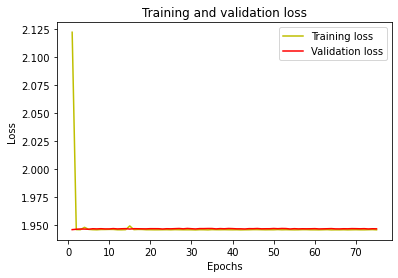

In [ ]:
#loss and accuracy curves 
loss = mod_fit.history['loss']
val_loss = mod_fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

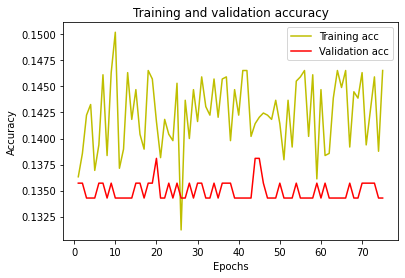

In [ ]:
acc = mod_fit.history['acc']
val_acc = mod_fit.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#predictions

y_pred = model.predict(X_ts)

17/17 [==============================] - 1s 26ms/step


In [ ]:
#one hot encoding --> probs from softmax to 1 and 0
y_pred_classes = np.argmax(y_pred, axis = 1) 

In [ ]:
y_true = np.argmax(Y_dx_ts, axis = 1) 

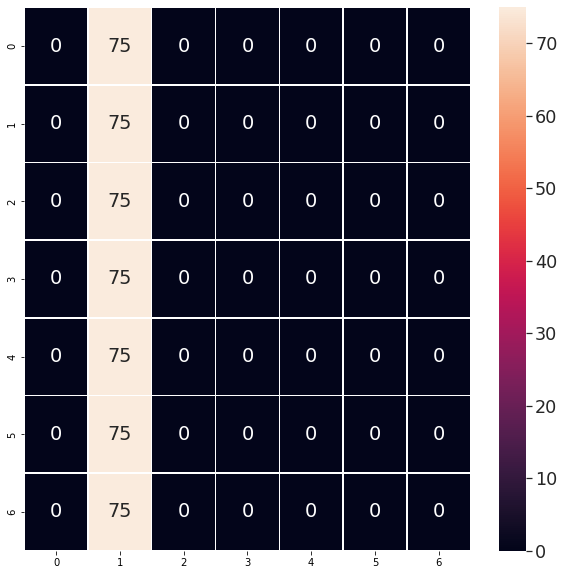

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [ ]:
y_val

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
Y_dx_ts

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

incorr_fraction = incorr_fraction.tolist()

incorr_fraction = [round(item, 2) for item in incorr_fraction]

incorr_fraction

[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

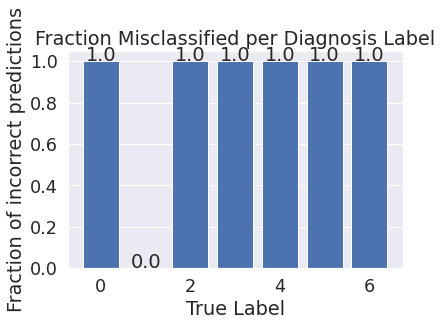

In [ ]:
#percent misclassified per dx
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
  
if __name__ == '__main__':
  plt.bar(np.arange(7), incorr_fraction)
  addlabels(np.arange(7), incorr_fraction)
  plt.title("Fraction Misclassified per Diagnosis Label")
  plt.xlabel('True Label')
  plt.ylabel('Fraction of incorrect predictions')